In [8]:
ls /home/dfulu/model_outputs/outputs/global_hadgem3_to_era5

checkpoints/  config.yaml  images/  index.html


In [104]:
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from climatetranslation.unit.data import (
    get_dataset, 
    dataset_time_overlap, 
    any_calendar_to_datetime,
    construct_regridders,
    even_lat_lon,
    get_land_mask,
    precip_kilograms_to_mm
)

from climatetranslation.unit.translate import (
    network_translate_constructor,
    get_data_transformer
)
from climatetranslation.unit.utils import get_config

from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

In [105]:
conf = get_config("/home/dfulu/model_outputs/outputs/global_hadgem3_to_era5/config.yaml")

In [106]:
conf['level_vars']

{0: ['pr'], 2: ['tas', 'tasmin', 'tasmax'], 5500: ['z500']}

In [107]:
def select_months(da, months, drop=False):
    in_months = xr.DataArray(np.isin(da['time.month'], months), coords=[da.time])
    return da.where(in_months, drop=drop)

def common_min_max(das):
    vmin = min([da.min() for da in das])
    vmax = max([da.max() for da in das])
    return vmin, vmax

In [108]:
conf_levels = conf['level_vars']
bbox = conf['bbox']

In [112]:
model = 'era5'
other_model = ({'era5','hadgem3'} - {model}).pop()

ds_target = get_dataset(f"/datadrive/{model}/all_hist{'_global' if model=='era5' else ''}_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_base = get_dataset(f"/datadrive/{other_model}/all_hist{'_global' if other_model=='era5' else ''}_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_trans = get_dataset(f"/datadrive/{other_model}/all_hist_to_{model}_zarr", 
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)

rg_t, rg_b = construct_regridders(
    ds_target, 
    ds_base, 
    resolution_match='downscale', 
    scale_method='conservative', 
    periodic=False)

if rg_t is not None:
    ds_target = rg_t(ds_target)
if rg_b is not None:
    ds_base = rg_b(ds_base)
    
if conf['time_range'] is not None:
    if conf['time_range'] == 'overlap':
        ds_target, ds_base, ds_trans = dataset_time_overlap([ds_target, ds_base, ds_trans])
    elif isinstance(conf['time_range'], dict):
        time_slice = slice(conf['time_range']['start_date'], conf['time_range']['end_date'])
        ds_target, ds_base, ds_trans = [ds.sel(time=time_slice) for ds in [ds_target, ds_base, ds_trans]]
    else:
        raise ValueError("time_range not valid : {}".format(conf['time_range']))

Create weight file: conservative_360x720_324x432.nc
Remove file conservative_360x720_324x432.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T12:00:00)


In [113]:
from skimage.metrics import structural_similarity as ssim

def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin).values

def find_closest(da_ref, da_search, use_ssim=True):
    if use_ssim:
        r = calc_range([da_search, da_ref])
        s = ssim(
            np.tile(da_ref.values,(len(da_search.time),1,1)), 
            da_search.values, 
            data_range=r, 
            full=True
        )[1].mean(axis=(-1,-2))
        n = s.argmax()
    else:
        s  = ((np.tile(da_ref.values,(len(da_search.time),1,1)) - da_search.values)**2).mean(axis=(-1,-2))
        n = s.argmin()
    return n, da_search.isel(time=n)

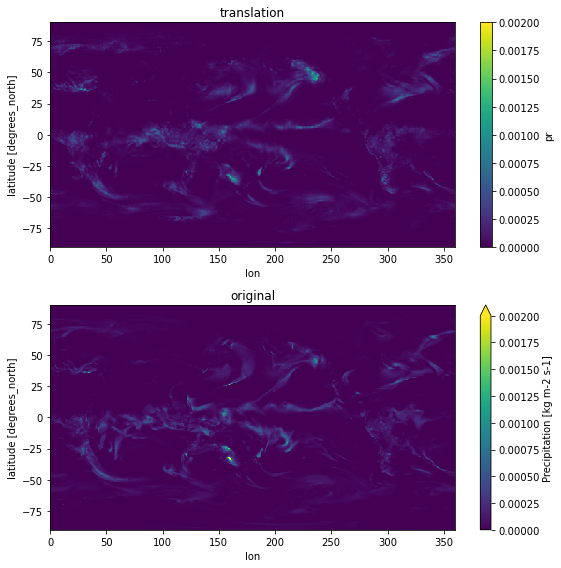

In [114]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
vmax = 0.002
ds_trans.pr.isel(time=0, run=0).plot(ax=ax1, vmax=vmax)
ax1.set_title('translation')
ds_base.pr.isel(time=0, run=0).plot(ax=ax2, vmax=vmax)
ax2.set_title('original')
plt.tight_layout()

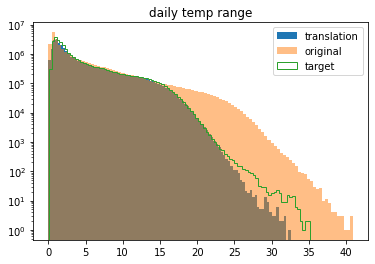

In [115]:
tslice = slice(0, 1000, 5)

(ds_trans.tasmax-ds_trans.tasmin).isel(time=tslice).plot.hist(bins=100, label='translation');
(ds_base.tasmax-ds_base.tasmin).isel(time=tslice).plot.hist(bins=100, alpha=0.5, label='original');
(ds_target.tasmax-ds_target.tasmin).isel(time=tslice).plot.hist(bins=100, histtype='step', label='target');
plt.yscale('log')
plt.title('daily temp range')
plt.legend()
plt.show()

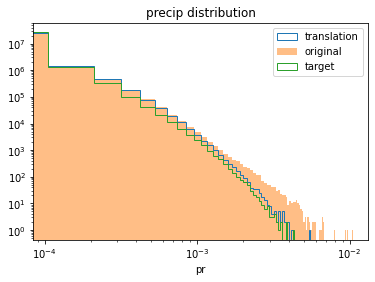

In [171]:
tslice = slice(0, 1000, 5)
m = float(max([(ds.pr).isel(time=tslice).max().compute() for ds in [ds_trans, ds_base, ds_target]]))
bins = np.linspace(0,m, 100)

rtr = (ds_trans.pr).isel(time=tslice).plot.hist(bins=bins,histtype='step', label='translation');
rba = (ds_base.pr).isel(time=tslice).plot.hist(bins=bins, alpha=0.5, label='original');
rta = (ds_target.pr).isel(time=tslice).plot.hist(bins=bins, histtype='step', label='target');
plt.yscale('log')
plt.title('precip distribution')
plt.xscale('log')
plt.legend()
plt.show()

In [218]:
cst - csta

array([-20.0025132 ,  -5.19287783,  31.70529045,  59.38272201,
        75.97405467,  85.60508228,  91.25010986,  94.98648939,
        97.190475  ,  98.61240802,  99.39599333, 100.03539809,
       100.52560136, 100.81671075, 101.01443047, 101.19465615,
       101.35511514, 101.48275297, 101.56292961, 101.62064411,
       101.64881428, 101.66699541, 101.69791389, 101.74511082,
       101.77618786, 101.79775151, 101.81735964, 101.82026651,
       101.83532936, 101.83844763, 101.84167161, 101.84167161,
       101.85541316, 101.85541316, 101.87364714, 101.88115213,
       101.87343573, 101.88136354, 101.88136354, 101.88553886,
       101.88125784, 101.88125784, 101.88125784, 101.88125784,
       101.88125784, 101.88125784, 101.88125784, 101.88125784,
       101.88125784, 101.88125784, 101.88125784, 101.88670161,
       101.88670161, 101.88670161, 101.88670161, 101.88670161,
       101.88670161, 101.88670161, 101.88670161, 101.88670161,
       101.88670161, 101.88670161, 101.88670161, 101.88

[]

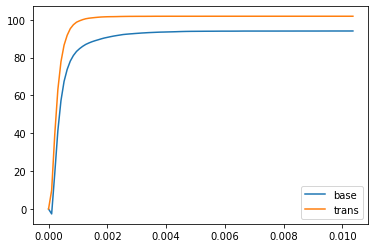

In [222]:
b = bins[:-1] # 0.5*(bins[1:]+bins[:-1])
cst = np.cumsum(b*rtr[0])
csb = np.cumsum(b*rba[0])
csta = np.cumsum(b*rta[0])

plt.plot(b, csb - csta, label='base')
plt.plot(b, cst - csta, label='trans')
#plt.yscale('log')
#plt.xscale('log')

plt.legend()
plt.plot()

In [215]:
[((ds.pr).isel(time=tslice)).mean().compute() for ds in [ds_trans, ds_base, ds_target]]

[<xarray.DataArray 'pr' ()>
 array(3.10324396e-05), <xarray.DataArray 'pr' ()>
 array(2.9377961e-05, dtype=float32), <xarray.DataArray 'pr' ()>
 array(2.75121397e-05)]

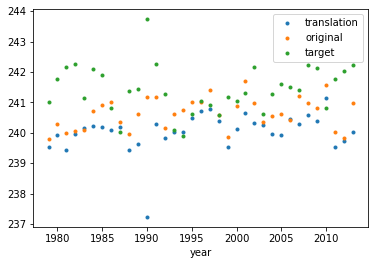

In [79]:
import copy
for ds, title in zip([ds_trans, ds_base, ds_target], ['translation', 'original', 'target']):
    ds = copy.deepcopy(ds)
    cos_weight = np.cos(ds.lat)
    cos_weight = cos_weight/cos_weight.sum()
    ds_ = (ds.tas*cos_weight).isel(time=slice(None, None, 5)).sum(dim='lat').mean(dim=('run', 'lon'))
    ds_.groupby('time.year').mean().plot(marker='.', linestyle='', label=title)
plt.legend()
plt.show()

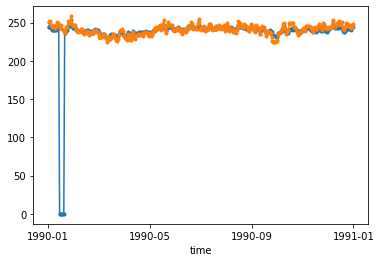

In [95]:

cos_weight = np.cos(ds_trans.lat)
cos_weight = cos_weight/cos_weight.sum()
(
    (ds_trans.sel(time='1990').tas*cos_weight)
    .sum(dim='lat')
    .mean(dim=('run', 'lon'))
    .plot(marker='.')
)

cos_weight = np.cos(ds_trans.lat)
cos_weight = cos_weight/cos_weight.sum()
(
    (ds_base.sel(time='1990').tas*cos_weight)
    .sum(dim='lat')
    .mean(dim=('run', 'lon'))
    .plot(marker='.')
)

In [90]:
mask = (
    (ds_trans.sel(time='1990').tas*cos_weight)
    .sum(dim='lat')
    .mean(dim=('run', 'lon')) < 50 
)

mask.where(mask, drop=True).time.values

array([cftime.Datetime360Day(1990, 1, 14, 12, 0, 0, 0),
       cftime.Datetime360Day(1990, 1, 15, 12, 0, 0, 0),
       cftime.Datetime360Day(1990, 1, 16, 12, 0, 0, 0),
       cftime.Datetime360Day(1990, 1, 17, 12, 0, 0, 0),
       cftime.Datetime360Day(1990, 1, 18, 12, 0, 0, 0),
       cftime.Datetime360Day(1990, 1, 19, 12, 0, 0, 0)], dtype=object)

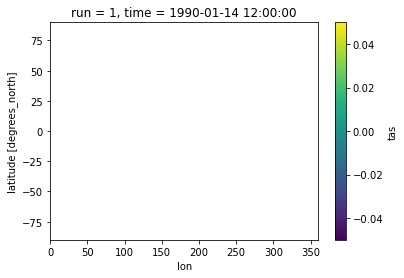

In [94]:
ds_trans.tas.sel(time='1990').where(mask, drop=True).isel(time=0).plot()

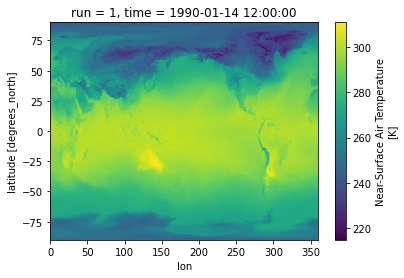

In [93]:
ds_base.tas.sel(time='1990').where(mask, drop=True).isel(time=0).plot()

In [49]:
for ds, title in zip([ds_trans, ds_base, ds_target], ['translation', 'original', 'target']):
    print(ds.pr.isel(time=tslice).mean().compute())

<xarray.DataArray 'pr' ()>
array(3.10324396e-05)
<xarray.DataArray 'pr' ()>
array(2.9377961e-05, dtype=float32)
<xarray.DataArray 'pr' ()>
array(2.75121397e-05)


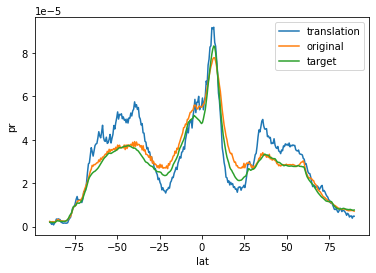

In [39]:
tslice = slice(0, 1000, 5)

ds_trans.pr.isel(time=tslice).mean(dim=('time', 'run', 'lon')).plot(label='translation');
ds_base.pr.isel(time=tslice).mean(dim=('time', 'run', 'lon')).plot(label='original');
ds_target.pr.isel(time=tslice).mean(dim=('time', 'run', 'lon')).plot(label='target');
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

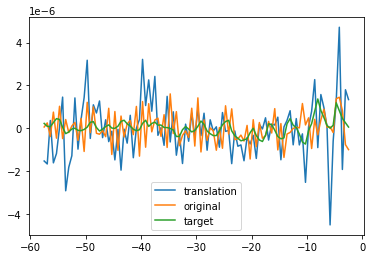

In [47]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=9

for ds, title in zip([ds_trans, ds_base, ds_target], ['translation', 'original', 'target']):
#for ds, title in zip([ds_base], ['base']):

    ds_m = ds.pr.isel(time=tslice).sel(**sel).mean(dim=('time', 'run', 'lon')).compute()

    plt.plot(
        ds_m.lat.values[w//2:-w//2+1],
        moving_average((ds_m), 1)[w//2:-w//2+1] - 
        moving_average((ds_m), w),
        label=title
    )
plt.legend()

In [8]:
ds_ = ds_trans.tas.isel(time=slice(None, None, 10)).mean(dim=('time', 'run')).compute()

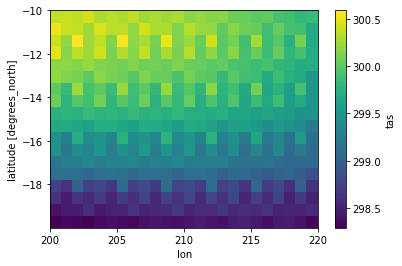

In [9]:
plt.figure(figsize=(6, 4))
ds_.sel(lat=slice(-20, -10), lon=slice(200, 220)).plot()

In [29]:
ds_.sel(lat=slice(-20, -10), lon=slice(200, 220)).assign_coords(coords=dict(n=0)).expand_dims('n')

<xarray.DataArray 'tas' (n: 1, lat: 18, lon: 24)>
array([[[298.30032605, 298.33967129, 298.32177657, 298.29294433,
         298.35695846, 298.38505079, 298.35920585, 298.335143  ,
         298.3964739 , 298.43134529, 298.40078036, 298.38579889,
         298.43599586, 298.47055012, 298.42938189, 298.3940374 ,
         298.4700052 , 298.49912147, 298.44165194, 298.37447134,
         298.44714316, 298.45503571, 298.40427605, 298.3239525 ],
        [298.40331343, 298.48073817, 298.47769407, 298.58860957,
         298.4495831 , 298.51245074, 298.51787591, 298.63493371,
         298.50879128, 298.56114159, 298.57631483, 298.65883608,
         298.53406791, 298.57391145, 298.58397982, 298.66935716,
         298.54678927, 298.59067872, 298.56635501, 298.63075857,
         298.50444887, 298.54046073, 298.51685173, 298.56227164],
        [298.62048314, 298.47162699, 298.63920416, 298.55576435,
         298.68844631, 298.52021718, 298.68760151, 298.59992318,
         298.74349331, 298.54652242, 298.72928769, 298.61839517,
         298.7774523 , 298.55533145, 298.7629462 , 298.61871575,
         298.77755869, 298.53644522, 298.71662015, 298.57453938,
         298.74450817, 298.49412972, 298.67097054, 298.50179835],
        [298.73260039, 298.62450746, 299.01758428, 298.73630343,
         298.78223477, 298.66597763, 299.07633216, 298.7410598 ,
...
         300.17553514, 299.9077327 , 300.05504422, 299.87026958,
         300.04106547, 299.79136614, 299.90899623, 299.71210629],
        [300.40699816, 300.20319492, 300.58768022, 300.25149134,
         300.357415  , 300.16261266, 300.55327061, 300.19562913,
         300.2995331 , 300.12093539, 300.50918192, 300.14129333,
         300.24232284, 300.05218905, 300.42357097, 300.0136557 ,
         300.10518211, 299.88926438, 300.26760943, 299.86921756,
         299.9832953 , 299.7534406 , 300.10738322, 299.68769866],
        [300.51714984, 300.39544634, 300.38592451, 300.25702982,
         300.45304353, 300.3437052 , 300.35234272, 300.20364743,
         300.40972867, 300.30127414, 300.30947915, 300.14321182,
         300.33649361, 300.23097877, 300.21959325, 300.02876325,
         300.18013495, 300.07004411, 300.05360139, 299.88345232,
         300.03500004, 299.91189404, 299.89438588, 299.69431823],
        [300.36517713, 300.3928451 , 300.35925132, 300.41848282,
         300.30172482, 300.34293914, 300.30365711, 300.36547459,
         300.25744287, 300.29485215, 300.25121132, 300.29600708,
         300.19067086, 300.21390143, 300.16758379, 300.18140895,
         300.07547844, 300.06684192, 300.00884399, 300.02636363,
         299.92108429, 299.8961944 , 299.81755776, 299.8372585 ]]])
Coordinates:
  * lat      (lat) float32 -19.72222 -19.166664 ... -10.83333 -10.277775
  * lon      (lon) float32 200.41666 201.25 202.08333 ... 218.75 219.58333
  * n        (n) int64 0

In [48]:
(r'(CAM5 $\rightarrow$ HadGEM3) - CAM5')

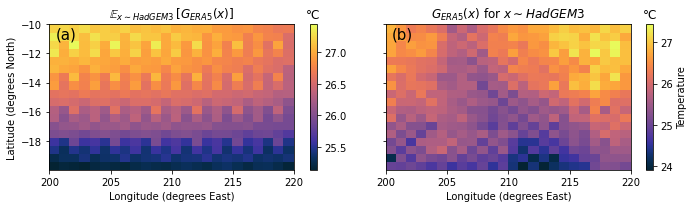

In [115]:
import cmocean

sel = dict(lat=slice(-20, -10), lon=slice(200, 220))
ds_plots =[
        dsh.sel(**sel).assign_coords(coords=dict(n=n)).expand_dims('n') - 273.15
        for n, dsh in enumerate([
            ds_, 
            ds_trans.tas.isel(time=0).drop('time'), 
        ])
    ] 

fig, axes = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
for i, (ds_plot, ax) in enumerate(zip(ds_plots, axes)):
    if i==1:
        cbar_kwargs = {'label':'Temperature'}
    else:
        cbar_kwargs = {'label':None}
    grid = ds_plot.plot(ax=ax, cmap=cmocean.cm.thermal, cbar_kwargs=cbar_kwargs)
    
    grid.colorbar.ax.set_title('°C')
    if i==0:
        ax.set_ylabel('Latitude (degrees North)')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Longitude (degrees East)')

for ax, title, letter in zip(
        axes, 
        [
            r'$\mathbb{E}_{x \sim HadGEM3}\,[G_{ERA5}(x)]$', 
             r'$G_{ERA5}(x)$ for $x \sim HadGEM3$', 
        ],
        ['a','b']
    ):
    ax.set_title(title)
    ax.text(200.5,-11, f"({letter})", {'fontsize':15})
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

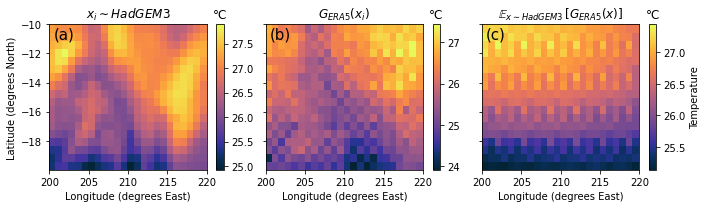

In [120]:
import cmocean

sel = dict(lat=slice(-20, -10), lon=slice(200, 220))
ds_plots =[
        dsh.sel(**sel).assign_coords(coords=dict(n=n)).expand_dims('n') - 273.15
        for n, dsh in enumerate([
            ds_base.tas.isel(time=0),
            ds_trans.tas.isel(time=0).drop('time'), 
            ds_, 
        ])
    ] 

fig, axes = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)
for i, (ds_plot, ax) in enumerate(zip(ds_plots, axes)):
    if i==2:
        cbar_kwargs = {'label':'Temperature'}
    else:
        cbar_kwargs = {'label':None}
    grid = ds_plot.plot(ax=ax, cmap=cmocean.cm.thermal, cbar_kwargs=cbar_kwargs)
    
    grid.colorbar.ax.set_title('°C')
    if i==0:
        ax.set_ylabel('Latitude (degrees North)')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Longitude (degrees East)')

for ax, title, letter in zip(
        axes, 
        [
            r'$x_i \sim HadGEM3$',
             r'$G_{ERA5}(x_i)$', 
            r'$\mathbb{E}_{x \sim HadGEM3}\,[G_{ERA5}(x)]$', 
        ],
        ['a','b','c']
    ):
    ax.set_title(title)
    ax.text(200.5,-11, f"({letter})", {'fontsize':15})
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

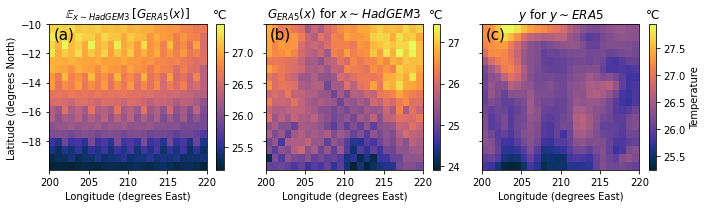

In [114]:
import cmocean

sel = dict(lat=slice(-20, -10), lon=slice(200, 220))
ds_plots =[
        dsh.sel(**sel).assign_coords(coords=dict(n=n)).expand_dims('n') - 273.15
        for n, dsh in enumerate([
            ds_, 
            ds_trans.tas.isel(time=0).drop('time'), 
            ds_target.tas.isel(time=1)
        ])
    ] 

fig, axes = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)
for i, (ds_plot, ax) in enumerate(zip(ds_plots, axes)):
    if i==2:
        cbar_kwargs = {'label':'Temperature'}
    else:
        cbar_kwargs = {'label':None}
    grid = ds_plot.plot(ax=ax, cmap=cmocean.cm.thermal, cbar_kwargs=cbar_kwargs)
    
    grid.colorbar.ax.set_title('°C')
    if i==0:
        ax.set_ylabel('Latitude (degrees North)')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Longitude (degrees East)')

for ax, title, letter in zip(
        axes, 
        [
            r'$\mathbb{E}_{x \sim HadGEM3}\,[G_{ERA5}(x)]$', 
             r'$G_{ERA5}(x)$ for $x \sim HadGEM3$', 
             r'$y$ for $y \sim ERA5$'
        ],
        ['a','b','c']
    ):
    ax.set_title(title)
    ax.text(200.5,-11, f"({letter})", {'fontsize':15})
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

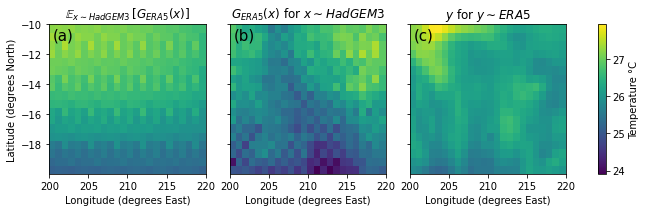

In [82]:

sel = dict(lat=slice(-20, -10), lon=slice(200, 220))
ds_plot = xr.merge(
    [
        dsh.sel(**sel).assign_coords(coords=dict(n=n)).expand_dims('n') 
        for n, dsh in enumerate([
            ds_, 
            ds_trans.tas.isel(time=0).drop('time'), 
            ds_target.tas.isel(time=1)
        ])
    ]) - 273.15

grid = ds_plot.tas.plot(col='n', cbar_kwargs={'label': 'Temperature °C'})
grid.set_ylabels('Latitude (degrees North)')
grid.set_xlabels('Longitude (degrees East)')

for ax, title, letter in zip(
        [ax for axes in grid.axes for ax in axes], 
        [
            r'$\mathbb{E}_{x \sim HadGEM3}\,[G_{ERA5}(x)]$', 
             r'$G_{ERA5}(x)$ for $x \sim HadGEM3$', 
             r'$y$ for $y \sim ERA5$'
        ],
        ['a','b','c']
    ):
    ax.set_title(title)
    ax.text(200.5,-11, f"({letter})", {'fontsize':15})
plt.show()

In [12]:
prs = [ds.pr.sel(lat=slice(-2, 30), lon=slice(55, 100)).load() for ds in [ds_target, ds_base, ds_trans]]

In [13]:
results = []
with ProgressBar(dt=10):
    for pr in prs:
        results.append(select_months(pr.isel(run=0), [6, 7, 8, 9], drop=True).mean(dim='time').compute())

In [19]:
samples = [select_months(pr.isel(run=0), [6, 7, 8, 9], drop=True).sel(time="1981-07-05") for pr in prs]
[s.time.values for s in samples]

[numpy.datetime64('1981-07-05T00:00:00.000000000'),
 array([cftime.Datetime360Day(1981, 7, 5, 12, 0, 0, 0)], dtype=object),
 array([cftime.Datetime360Day(1981, 7, 5, 12, 0, 0, 0)], dtype=object)]

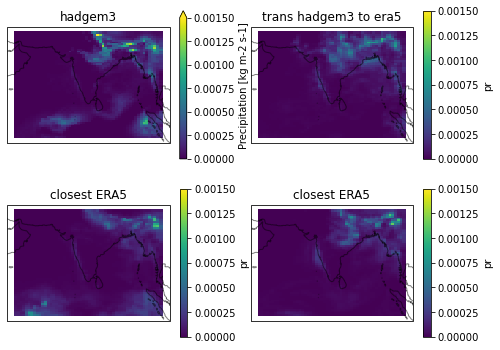

In [26]:
vmin, vmax = 0, 0.0015
plt.figure(figsize=(8,6))
titles = [other_model, f"trans {other_model} to {model}"]

for i, title in enumerate(titles):
    ax1 = plt.subplot(221+i, projection=ccrs.PlateCarree())
    (samples[i+1]).plot(ax=ax1, vmin=vmin, vmax=vmax)
    
    ax2 = plt.subplot(223+i, projection=ccrs.PlateCarree())
    find_closest(samples[i+1], prs[0].isel(run=0), use_ssim=0)[1].plot(ax=ax2, vmin=vmin, vmax=vmax)
    
    ax1.coastlines(alpha=0.5)
    ax1.set_title(title)
    ax2.coastlines(alpha=0.5)
    ax2.set_title('closest ERA5')
    
plt.show()

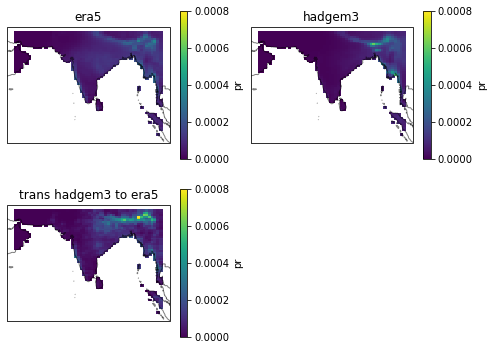

In [27]:
land_mask = 1

vmin, vmax =  common_min_max(results[:3])
#vmin, vmax = 0, 0.00015

plt.figure(figsize=(8,6))
axes = [plt.subplot(221+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"trans {other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax, vmin=vmin, vmax=vmax)
    else:
        da.plot(ax=ax, vmin=vmin, vmax=vmax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

## Precip Peru

In [70]:
from climatetranslation.unit.data import any_calendar_to_datetime

In [73]:
ds_target.time.values

array(['1979-01-02T00:00:00.000000000', '1979-01-03T00:00:00.000000000',
       '1979-01-04T00:00:00.000000000', ...,
       '2013-12-28T00:00:00.000000000', '2013-12-29T00:00:00.000000000',
       '2013-12-30T00:00:00.000000000'], dtype='datetime64[ns]')

array([datetime.datetime(1979, 1, 2, 0, 0),
       datetime.datetime(1979, 1, 3, 0, 0),
       datetime.datetime(1979, 1, 4, 0, 0), ...,
       datetime.datetime(2013, 12, 28, 0, 0),
       datetime.datetime(2013, 12, 29, 0, 0),
       datetime.datetime(2013, 12, 30, 0, 0)], dtype=object)

In [133]:
import pandas as pd



def nino_34_index(da, modify_dates=False, three_month_averaging=True):
    """This function calculates the ONI index based on the protocol described here
    http://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
    args:
        cube: xarray of sea surface temperatures
        as_pandas: return as pandas dataframe. Else as iris cube
        averaging: apply 3 month averaging to index. Else just 1 month
    output:
        xarray
        """
    da_new = xr.zeros_like(da.isel(lat=0, lon=0)).drop(['lat', 'lon'])
    
    if modify_dates:
        dates = np.array([any_calendar_to_datetime(x) for x in da.time.values])
    else:
        dates = da.time.values
    
    months = xr.DataArray(np.vectorize(lambda x : x.month)(dates),
                  dims=['time'],
                  coords={'time':da.time})
    months.name='month'
    
    years = xr.DataArray(np.vectorize(lambda x : x.year)(dates),
                  dims=['time'],
                  coords={'time':da.time})
    year_months = years*100+months
    year_months.name='year_months'
    
    sst_clim = da.groupby(months).mean(dim='time')
    sst_anom = da.groupby(months) - sst_clim
    
    sst_anom_nino34 = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))
    sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
    
    # takes means over months
    sst_anom_nino34_mean = sst_anom_nino34_mean.groupby(year_months).mean()
    
    if three_month_averaging:
        oni = sst_anom_nino34_mean.rolling(year_months=3, center=True).mean()
        name = '3_month_mean_ONI'
    else:
        oni = sst_anom_nino34_mean
        name = '1_month_mean_nino34'
    return da_new.groupby(year_months) + oni        


def plot_nino_rain(ds, modify_dates=False):
    ds_nino = nino_34_index(ds.tas, modify_dates=modify_dates).compute()
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    #ds.pr.sel(lat=-5.2, lon=360-80.6, method='nearest').plot(ax=ax1, color='k')
    ds.pr.sel(lat=3.6, lon=283, method='nearest').plot(ax=ax1, color='k')
    ds_nino.plot(ax=ax2, color='r')
    ax1.set_ylabel('Daily Precip', color='k')
    ax2.set_ylabel('NINO 3.4 INDEX', color='r')
    return

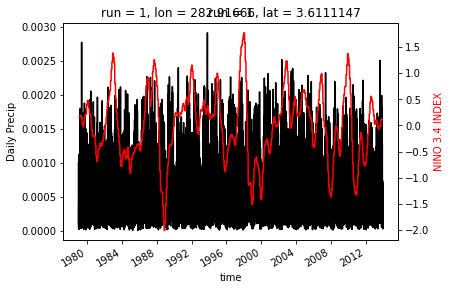

In [134]:
plot_nino_rain(ds_target, modify_dates=True)

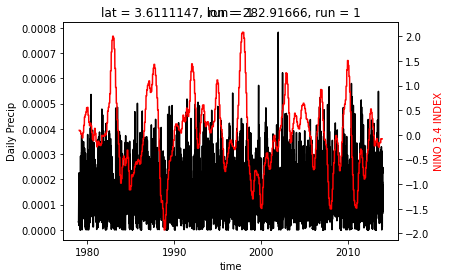

In [135]:
plot_nino_rain(ds_base, modify_dates=False)

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


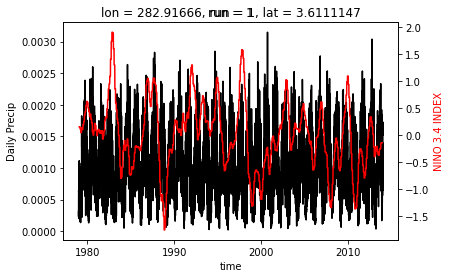

In [136]:
plot_nino_rain(ds_trans, modify_dates=False)

In [103]:
ds_pr_mean = ds_target.pr.mean(dim='time').compute()

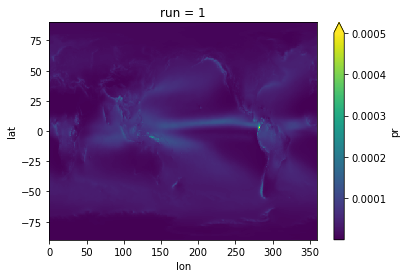

In [121]:
(ds_pr_mean).plot(vmax=0.0005)

In [110]:
ds_pr_base_mean = ds_base.pr.mean(dim='time').compute()

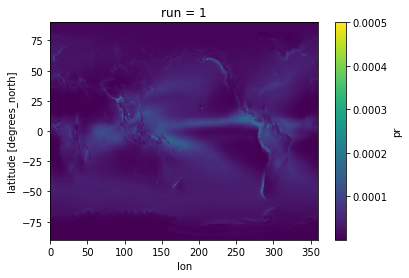

In [122]:
(ds_pr_base_mean).plot(vmax=0.0005)

In [112]:
ds_pr_trans_mean = ds_trans.pr.mean(dim='time').compute()

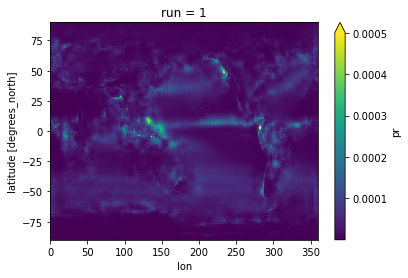

In [123]:
(ds_pr_trans_mean).plot(vmax=0.0005)

In [126]:
ds_pr_trans_mean.argmax(dim=['lat', 'lon'])

{'lat': <xarray.DataArray 'pr' (run: 1)>
 array([168])
 Coordinates:
   * run      (run) int64 1, 'lon': <xarray.DataArray 'pr' (run: 1)>
 array([339])
 Coordinates:
   * run      (run) int64 1}

In [131]:
ds_pr_trans_mean.isel(lon=339, lat=168)

<xarray.DataArray 'pr' (run: 1)>
array([0.00100905])
Coordinates:
    lon      float32 282.91666
  * run      (run) int64 1
    lat      float32 3.6111147

In [9]:
ds_target.time

<xarray.DataArray 'time' (time: 12782)>
array(['1979-01-02T00:00:00.000000000', '1979-01-03T00:00:00.000000000',
       '1979-01-04T00:00:00.000000000', ..., '2013-12-28T00:00:00.000000000',
       '2013-12-29T00:00:00.000000000', '2013-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2013-12-30

In [71]:
from climatetranslation.diagnostics.indices.utils import precip_to_mm

In [74]:
def extract_trb_rain(ds):
    return (
        ds.pr
        .sel(lon=slice(20, 30), lat=slice(-25, 25))
        .mean(dim='lon')
        .sel(time=slice('1990', '2010'), run=1)
    )

def mean_month(da):
    return da.resample(time="1MS").mean()

In [75]:
trb_target = mean_month(extract_trb_rain(precip_kilograms_to_mm(ds_target)**0.25)).compute()

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


In [76]:
trb_base = mean_month(extract_trb_rain(precip_kilograms_to_mm(ds_base)**0.25)).compute()

In [77]:
trb_trans = mean_month(extract_trb_rain(precip_kilograms_to_mm(ds_trans)**0.25)).compute()

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


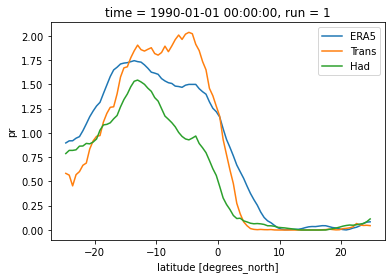

In [228]:
ax = plt.subplot(111)
for da, lab in zip([trb_target, trb_trans, trb_base], ['ERA5', 'Trans', 'Had']):
    da.isel(time=0).plot(ax=ax, label=lab)
plt.legend()
#plt.tight_layout()
plt.show()

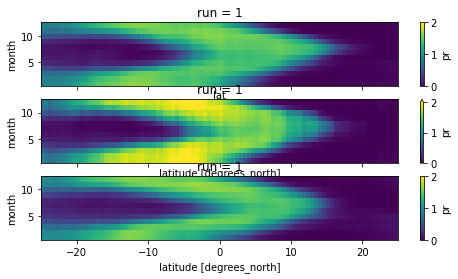

In [93]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,4))
for da, lab, ax in zip([trb_target, trb_trans, trb_base], ['ERA5', 'Trans', 'Had'], axes):
    da.groupby(da.time.dt.month).mean().plot(ax=ax, label=lab, vmin=0, vmax=2)
#plt.tight_layout()
plt.show()

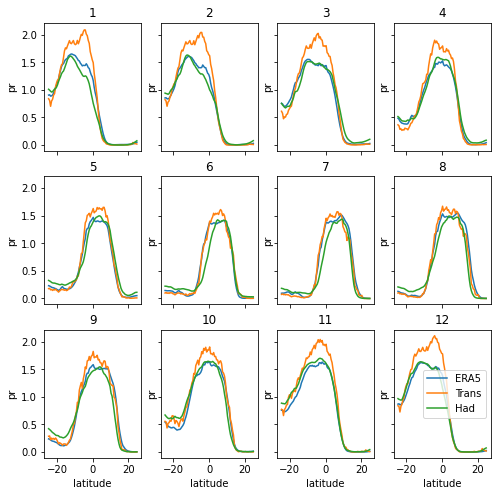

In [103]:
fig, axes = plt.subplots(3,4,sharex=True, sharey=True, figsize=(8,8))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    for da, lab in zip([trb_target, trb_trans, trb_base], ['ERA5', 'Trans', 'Had']):
        da.groupby(da.time.dt.month).mean().isel(month=i).plot(ax=ax, label=lab)#vmin=0, vmax=1.5)
    if i < 8:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('latitude')
        
    ax.set_title(i+1)
plt.legend()
plt.show()